In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_folder = "./RGBaHa(26-03-23)"
images_folder = "RGBaHa"
table_file = "data.csv"

In [4]:
target_column = "hgt"

In [5]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path, table_path):
        super().__init__()
        
        self.table = pd.read_csv(table_path, index_col=0).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        
        self.max_h, self.max_w = 0, 0
        self.channel_mean, self.channel_std = 0, 0
        self.depth_max = 0
        images = []
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tiff")
            img_rgbd = skimage.io.imread(file_path)[:, :, [0, 1, 2, 4]].transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgbd.shape[2])
            self.max_w = max(self.max_w, img_rgbd.shape[3])
            images.append(torch.from_numpy(img_rgbd))
            self.depth_max = max(self.depth_max, img_rgbd[:, 3, :, :].max())
        
        padded_images = []
        rng = np.random.default_rng()
        for image in images:
            img_h, img_w = image.shape[2:]
            h_pos = rng.integers(0, self.max_h - img_h + 1)
            w_pos = rng.integers(0, self.max_w - img_w + 1)
            padded = torch.zeros(1, 4, self.max_h, self.max_w)
            padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
            padded_images.append(padded)
            
            image[:, :3, :, :] /= 255.
            image[:, 3, :, :] /= self.depth_max
            self.channel_mean += image.mean(dim=(0, 2, 3))
            self.channel_std += image.std(dim=(0, 2, 3))

        self.images = torch.cat(padded_images)
        
    def __getitem__(self, index):
        x = self.images[index].type(torch.FloatTensor)
        y_regr = torch.tensor(self.table.iloc[index].loc[target_column])
        return x, y_regr
    
    def __len__(self):
        return len(self.table)

In [6]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, all_transform=None, rgb_only_transform=None):
        self.subset = subset
        self.all_transform = all_transform
        self.rgb_transform = rgb_only_transform

    def __getitem__(self, index):
        x, y_regr = self.subset[index]
        if self.all_transform:
            x = self.all_transform(x)
        if self.rgb_transform:
            x[:3, :, :] = self.rgb_transform(x[:3, :, :])
        return x.type(torch.float), y_regr.type(torch.float)

    def __len__(self):
        return len(self.subset)

In [7]:
data = TreeDataset(os.path.join(data_folder, images_folder), os.path.join(data_folder, table_file))

In [8]:
train, val, test = random_split(data, [0.70, 0.20, 0.10])

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
augment_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
    tr.RandomApply([AddGaussianNoise()]),
    tr.RandomHorizontalFlip(),
    tr.RandomVerticalFlip(),
    # tr.RandomRotation(degrees=180),
    tr.RandomAffine(degrees=180, translate=(0.3, 0.4), scale=(0.4, 0.8)),
    # tr.RandomPerspective()
    
])

augment_rgb_transform = tr.Compose([
    tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    tr.RandomAdjustSharpness(0.5),
    tr.RandomAutocontrast(),
])

prepare_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
])

In [11]:
train_dataset = TreeDatasetFromSubset(train, augment_transform, augment_rgb_transform)
val_dataset = TreeDatasetFromSubset(val, prepare_transform)

Targets:
tensor(29.7500)


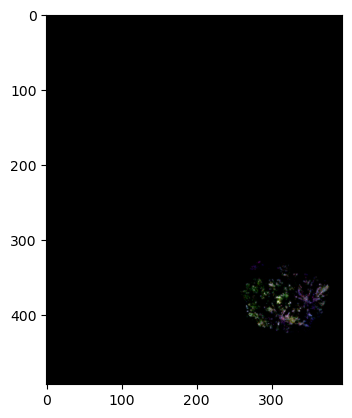

In [12]:
print("Targets:")
print(train_dataset[np.random.randint(0, 100)][1])
plt.imshow(train_dataset[np.random.randint(0, 100)][0][:3, :, :].movedim(0, -1))
plt.show()

In [13]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        stride = (2, 2) if in_channels != out_channels else (1, 1)

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, (1, 1), stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride, padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        residual = self.shortcut(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation(x)

        return x + residual


class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.blocks(x)
        return x

In [15]:
class ResNet18(nn.Module):
    def __init__(self, out_channels=32, layer_num=3, fc_regr_hidden=128, in_channels=4, classes_num=len(data.label_map)):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), padding=(1, 1), bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d((2, 2))
        self.layers = nn.Sequential(
            ResNetLayer(out_channels, out_channels),
            *[ResNetLayer(2**i * out_channels, 2**(i+1) * out_channels) for i in range(layer_num - 1)],
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        # predicting main characteristics
        self.fc_regr = nn.Sequential(
            nn.Linear(2**(layer_num - 1) * out_channels, fc_regr_hidden),
            nn.BatchNorm1d(fc_regr_hidden),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fc_regr_hidden, 1),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        x = self.layers(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x_regr = self.fc_regr(x)
        return x_regr.squeeze()

In [16]:
import IPython


def train_loop(model, dataloader, loss_regr_fn, optimizer, step=0.05, history_loss=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_loss = []
    percentage = 0
    
    for batch, (X, y_regr) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_regr = y_regr.to(device)
        pred_regr = model(X)
        loss = loss_regr_fn(pred_regr, y_regr)
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch / (num_batches - 1) >= percentage:
            percentage = int(batch / (num_batches - 1) / step) * step
            out.update(f'[{int(percentage * size)}/{size}] Batch RMSE Loss: {np.sqrt(loss.item()):>8f}')
    
    total_loss = np.mean(np.sqrt(train_loss))
    if history_loss is not None:
        history_loss.append(total_loss)
    return {'train_loss': total_loss}


def test_loop(model, dataloader, loss_regr_fn, history_loss=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    val_loss = []

    with torch.no_grad():
        for batch, (X, y_regr) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            torch.cuda.empty_cache()
            gc.collect()
        
            X = X.to(device)
            y_regr = y_regr.to(device)
            pred_regr = model(X)
            loss = loss_regr_fn(pred_regr, y_regr)
            val_loss.append(loss.item())
    
        total_loss = np.mean(np.sqrt(val_loss))
        print(f"Validation RMSE Loss: {total_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(total_loss)
    return {'val_loss': total_loss}

In [17]:
def plot_learning_process(train_loss, val_loss, title):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.plot(np.arange(0, len(train_loss)) + 1, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(title.split()[0])
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

In [27]:
loss_regr = nn.MSELoss()
epochs = 30

models_results = []
for chan in tqdm([8]):
    for layer_n in tqdm([3]):
        for fc_regr_hidden in tqdm([512]):
            net = ResNet18(out_channels=chan, layer_num=layer_n, fc_regr_hidden=fc_regr_hidden).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-7)

            train_loss = []
            val_loss = []

            models_results.append({"first_out_channel": chan, "layer_num": layer_n, "fc_regr_hidden": fc_regr_hidden})
            for epoch in range(epochs):
                print(f"Epoch {epoch+1}")
                print("-------------------------------")
                train_loop(net, train_dataloader, loss_regr, optimizer, history_loss=train_loss)
                test_loop(net, val_dataloader, loss_regr, history_loss=val_loss)
                scheduler.step(train_loss[-1])
            
            models_results[-1][f"train_{target_column}_RMSE"] = train_loss
            models_results[-1][f"val_{target_column}_RMSE"] = val_loss

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1
-------------------------------


'[318/318] Batch RMSE Loss: 16.628292'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 18.114252 

Epoch 2
-------------------------------


'[318/318] Batch RMSE Loss: 18.030923'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 17.271631 

Epoch 3
-------------------------------


'[318/318] Batch RMSE Loss: 13.502134'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 16.494585 

Epoch 4
-------------------------------


'[318/318] Batch RMSE Loss: 12.513283'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 15.665261 

Epoch 5
-------------------------------


'[318/318] Batch RMSE Loss: 13.195255'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 14.961098 

Epoch 6
-------------------------------


'[318/318] Batch RMSE Loss: 13.755802'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 14.250898 

Epoch 7
-------------------------------


'[318/318] Batch RMSE Loss: 11.858490'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 13.668155 

Epoch 8
-------------------------------


'[318/318] Batch RMSE Loss: 12.053241'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 13.001053 

Epoch 9
-------------------------------


'[318/318] Batch RMSE Loss: 10.033632'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 12.202253 

Epoch 10
-------------------------------


'[318/318] Batch RMSE Loss: 8.167212'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 11.719836 

Epoch 11
-------------------------------


'[318/318] Batch RMSE Loss: 8.367552'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 11.081714 

Epoch 12
-------------------------------


'[318/318] Batch RMSE Loss: 8.072888'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 11.033890 

Epoch 13
-------------------------------


'[318/318] Batch RMSE Loss: 9.842226'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 10.300230 

Epoch 14
-------------------------------


'[318/318] Batch RMSE Loss: 8.958196'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 9.985317 

Epoch 15
-------------------------------


'[318/318] Batch RMSE Loss: 8.314145'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 9.692237 

Epoch 16
-------------------------------


'[318/318] Batch RMSE Loss: 6.775386'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 9.159544 

Epoch 17
-------------------------------


'[318/318] Batch RMSE Loss: 7.959843'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.787400 

Epoch 18
-------------------------------


'[318/318] Batch RMSE Loss: 6.078734'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.501519 

Epoch 19
-------------------------------


'[318/318] Batch RMSE Loss: 5.694422'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.422528 

Epoch 20
-------------------------------


'[318/318] Batch RMSE Loss: 6.793205'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.164334 

Epoch 21
-------------------------------


'[318/318] Batch RMSE Loss: 6.477777'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.082278 

Epoch 22
-------------------------------


'[318/318] Batch RMSE Loss: 5.325753'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 7.912866 

Epoch 23
-------------------------------


'[318/318] Batch RMSE Loss: 5.581147'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.189133 

Epoch 24
-------------------------------


'[318/318] Batch RMSE Loss: 4.482988'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.019943 

Epoch 25
-------------------------------


'[318/318] Batch RMSE Loss: 5.473439'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 7.820684 

Epoch 26
-------------------------------


'[318/318] Batch RMSE Loss: 4.772515'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 7.667561 

Epoch 27
-------------------------------


'[318/318] Batch RMSE Loss: 4.778859'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.169793 

Epoch 28
-------------------------------


'[318/318] Batch RMSE Loss: 4.981112'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.564140 

Epoch 29
-------------------------------


'[318/318] Batch RMSE Loss: 5.223444'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.209188 

Epoch 30
-------------------------------


'[318/318] Batch RMSE Loss: 5.871943'

Batch #:   0%|          | 0/9 [00:00<?, ?it/s]

Batch #:   0%|          | 0/3 [00:00<?, ?it/s]

Validation RMSE Loss: 8.228498 



In [28]:
results_df = pd.DataFrame(models_results)

In [29]:
results_df

,first_out_channel,layer_num,fc_regr_hidden,train_hgt_RMSE,val_hgt_RMSE
0,8,3,512,"[18.038205447828798, 16.986710155478608, 16.02...","[18.114251981664033, 17.27163106538643, 16.494..."


In [30]:
expanded_df = results_df.set_index(["layer_num"]).apply(pd.Series.explode).reset_index()

expanded_df.index.name = "Epoch"
expanded_df.index = expanded_df.index + 1
expanded_df.dropna()

,layer_num,first_out_channel,fc_regr_hidden,train_hgt_RMSE,val_hgt_RMSE
Epoch,,,,,
1,3,8,512,18.038205,18.114252
2,3,8,512,16.98671,17.271631
3,3,8,512,16.029023,16.494585
4,3,8,512,15.062793,15.665261
5,3,8,512,14.348366,14.961098
6,3,8,512,13.542337,14.250898
7,3,8,512,12.413329,13.668155
8,3,8,512,11.63789,13.001053
9,3,8,512,10.885511,12.202253


first_out_channel      8
layer_num              3
fc_regr_hidden       512
Name: 0, dtype: object


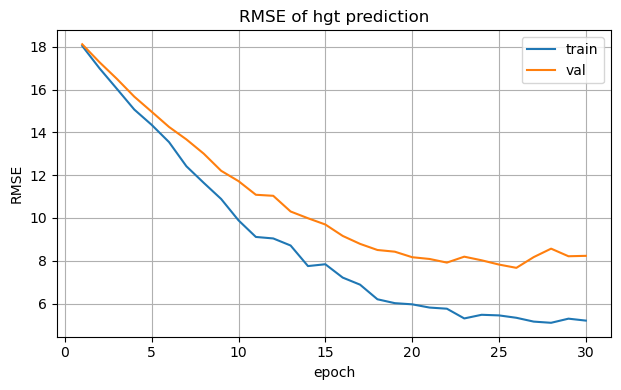

In [31]:
for i in range(len(results_df)):
    row = results_df.iloc[i]
    print(row[:3])
    plot_learning_process(row[f"train_{target_column}_RMSE"], row[f"val_{target_column}_RMSE"], f"RMSE of {target_column} prediction")

In [32]:
test_dataset = TreeDatasetFromSubset(test, prepare_transform)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [33]:
PATH = f"{target_column}_prediction_model.pt"
assert not os.path.exists(PATH), "There is a checkpoint already! Remove this assert to override"
torch.save({
    'epoch': epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_loop(net, test_dataloader, loss_regr)["val_loss"]
},
    PATH)

Batch #:   0%|          | 0/2 [00:00<?, ?it/s]

Validation RMSE Loss: 9.680201 



In [ ]:
model = ResNet18(out_channels=8, layer_num=3, fc_regr_hidden=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()